# 1. Import Libraries

In [1]:
import sqlite3
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 2. Read in the Data Tables

In [2]:
# Connect to the sqlite database and read the tables into pandas dataframe objects
conn = sqlite3.connect('coffee.db')
cursor = conn.cursor()

snd_tbl_query = "SELECT * FROM SND"
coffee_type_tbl_query = "SELECT * FROM coffee_type"
market_tbl_query = "SELECT * FROM market"
price_tbl_query = "SELECT * FROM price"

df_snd = pd.read_sql_query(snd_tbl_query, conn)
df_coffee_type = pd.read_sql_query(coffee_type_tbl_query, conn)
df_market = pd.read_sql_query(market_tbl_query, conn)
df_price = pd.read_sql_query(price_tbl_query, conn)

conn.close()

In [3]:
# Convert date columns from 'object' type to 'datetime64' type
df_snd['date'] = pd.to_datetime(df_snd['date'], format='%Y-%m-%d')
df_market['date'] = pd.to_datetime(df_market['date'], format='%Y-%m-%d')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y-%m-%d')

In [4]:
df_snd.head()

,date,coffee_type_id,certified_stock,total_consumption,total_stock,total_supply,total_demand
0,2001-12-31,1,1114.557832,4792.057525,4459.483456,1568.443583,785.610628
1,2002-01-31,1,1087.076160,4861.908518,4558.069021,1594.259096,744.775122
2,2002-02-28,1,1026.468713,4349.975139,4406.522032,1567.154395,769.710533
3,2002-03-31,1,961.625592,4647.049927,4120.613079,1518.538160,806.831154
4,2002-04-30,1,892.695043,4755.849295,3905.861783,1479.966651,806.272717


In [5]:
df_coffee_type.head()

,coffee_type_id,coffee_type
0,1,Arabica
1,2,Robusta


In [6]:
df_market.head()

,date,actvsproj,DXY,USDBRL
0,2001-12-31,act,116.750000,2.311
1,2002-01-31,act,120.239998,2.413
2,2002-02-28,act,119.160004,2.365
3,2002-03-31,act,118.620003,2.325
4,2002-04-30,act,115.190002,2.361


In [7]:
df_price

,date,coffee_type_id,actvsproj,price
0,2001-12-31,1,act,48.150000
1,2002-01-31,1,act,47.650000
2,2002-02-28,1,act,46.300000
3,2002-03-31,1,act,59.200000
4,2002-04-30,1,act,52.850000
5,2002-05-31,1,act,54.350000
6,2002-06-30,1,act,48.850000
7,2002-07-31,1,act,50.100000
8,2002-08-31,1,act,53.200000
9,2002-09-30,1,act,57.500000


In [42]:
# Merge data tables for model training
df = df_snd.merge(df_market, on=['date'], how='left') \
           .merge(df_price, on=['date','coffee_type_id','actvsproj'],how='left')

In [9]:
df

,date,coffee_type_id,certified_stock,total_consumption,total_stock,total_supply,total_demand,actvsproj,DXY,USDBRL,price
0,2001-12-31,1,1114.557832,4792.057525,4459.483456,1568.443583,785.610628,act,116.750000,2.311000,48.150000
1,2002-01-31,1,1087.076160,4861.908518,4558.069021,1594.259096,744.775122,act,120.239998,2.413000,47.650000
2,2002-02-28,1,1026.468713,4349.975139,4406.522032,1567.154395,769.710533,act,119.160004,2.365000,46.300000
3,2002-03-31,1,961.625592,4647.049927,4120.613079,1518.538160,806.831154,act,118.620003,2.325000,59.200000
4,2002-04-30,1,892.695043,4755.849295,3905.861783,1479.966651,806.272717,act,115.190002,2.361000,52.850000
5,2002-05-31,1,868.692722,5107.256599,3690.298284,1446.571024,796.266947,act,111.809998,2.518000,54.350000
6,2002-06-30,1,850.942251,4793.799663,3905.459673,1502.156224,777.536761,act,106.110001,2.817500,48.850000
7,2002-07-31,1,842.653449,4794.312965,4281.656682,1604.962357,820.182761,act,107.410004,3.460000,50.100000
8,2002-08-31,1,842.940626,4919.049115,4689.269366,1711.032319,833.930140,act,106.980003,3.007500,53.200000
9,2002-09-30,1,860.003702,4842.129057,5039.095538,1796.594941,821.454423,act,106.870003,3.760000,57.500000


In [10]:
# Assuming no missing data, let's split the data into train and test sets
from sklearn.model_selection import train_test_split

X = df.drop(['date', 'price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
from sklearn.model_selection import train_test_split

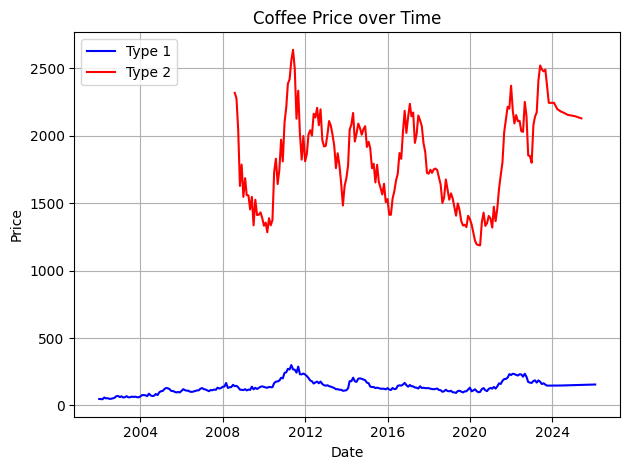

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your DataFrame is named df
df['date'] = pd.to_datetime(df['date'])

# Filter for coffee_type_id == 1 and plot
type1_data = df[df['coffee_type_id'] == 1]
plt.plot(type1_data['date'], type1_data['price'], label='Type 1', color='blue')

# Filter for coffee_type_id == 2 and plot
type2_data = df[df['coffee_type_id'] == 2]
plt.plot(type2_data['date'], type2_data['price'], label='Type 2', color='red')

# Title, labels and legend
plt.title("Coffee Price over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [43]:
df.head()

,date,coffee_type_id,certified_stock,total_consumption,total_stock,total_supply,total_demand,actvsproj,DXY,USDBRL,price
0,2001-12-31,1,1114.557832,4792.057525,4459.483456,1568.443583,785.610628,act,116.750000,2.311,48.15
1,2002-01-31,1,1087.076160,4861.908518,4558.069021,1594.259096,744.775122,act,120.239998,2.413,47.65
2,2002-02-28,1,1026.468713,4349.975139,4406.522032,1567.154395,769.710533,act,119.160004,2.365,46.30
3,2002-03-31,1,961.625592,4647.049927,4120.613079,1518.538160,806.831154,act,118.620003,2.325,59.20
4,2002-04-30,1,892.695043,4755.849295,3905.861783,1479.966651,806.272717,act,115.190002,2.361,52.85


In [44]:

df.coffee_type_id.value_counts()

coffee_type_id
1    290
2    203
Name: count, dtype: int64

In [60]:
# Merge data tables for model training
df = df_snd.merge(df_market, on=['date'], how='left') \
           .merge(df_price, on=['date','coffee_type_id','actvsproj'],how='left')

In [61]:
df = df.query('actvsproj=="act"')
df = df.drop(['actvsproj'], axis=1)  # adjust as needed

In [46]:
df.coffee_type_id.value_counts()

coffee_type_id
1    263
2    184
Name: count, dtype: int64

In [90]:
import xgboost as xgb
from sklearn.utils import shuffle

# Merge data tables for model training
df = df_snd.merge(df_market, on=['date'], how='left') \
           .merge(df_price, on=['date','coffee_type_id','actvsproj'],how='left') \
           .merge(df_coffee_type, on=['coffee_type_id'], how='left')

df = df.query('actvsproj=="act"')
df = df.drop(['actvsproj', 'coffee_type_id'], axis=1)

# Assuming df is your dataset, and 'price' is the column we're lagging
df['target'] = df['price'].shift(-1)
df = df[:-1]  # Remove last row since it will have NaN value for target

# Shuffle the dataset
df = shuffle(df, random_state=123)

# Define parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 1,
    'lambda': 10,
    'alpha': 0.5
}

num_round = 500
early_stopping_rounds = 20

coffee_types = ['Arabica', 'Robusta']
models = {}

for coffee in coffee_types:
    filtered_df = df[df['coffee_type'] == coffee]
    filtered_df.drop(['coffee_type'], axis=1,inplace=True)
    
    # Splitting data
    train_size = int(len(filtered_df) * 0.7)
    train_df, test_df = filtered_df.iloc[:train_size], filtered_df.iloc[train_size:]

    # Define the features and target
    X_train = train_df.drop(columns=['target', 'date'])
    y_train = train_df['target']
    X_test = test_df.drop(columns=['target', 'date'])
    y_test = test_df['target']

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    evals = [(dtrain, 'train'), (dvalid, 'eval')]

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        early_stopping_rounds=early_stopping_rounds
    )

    models[coffee] = model
    print(f"Best iteration for {coffee}: {model.best_iteration}")

[0]	train-rmse:46.77193	eval-rmse:250.31866
[1]	train-rmse:45.73133	eval-rmse:249.92538
[2]	train-rmse:44.31333	eval-rmse:249.65231
[3]	train-rmse:42.94776	eval-rmse:249.43703
[4]	train-rmse:41.60622	eval-rmse:249.23083
[5]	train-rmse:40.41906	eval-rmse:249.03784
[6]	train-rmse:39.60986	eval-rmse:248.70866
[7]	train-rmse:38.45280	eval-rmse:248.55425
[8]	train-rmse:37.34361	eval-rmse:248.38797
[9]	train-rmse:36.30413	eval-rmse:248.16173
[10]	train-rmse:35.27539	eval-rmse:247.93719
[11]	train-rmse:34.32807	eval-rmse:247.73507
[12]	train-rmse:33.40453	eval-rmse:247.62825
[13]	train-rmse:32.45861	eval-rmse:247.44508
[14]	train-rmse:31.87078	eval-rmse:247.26113
[15]	train-rmse:31.01629	eval-rmse:247.08887
[16]	train-rmse:30.23465	eval-rmse:247.01000
[17]	train-rmse:29.42128	eval-rmse:246.90399
[18]	train-rmse:28.68720	eval-rmse:246.77125
[19]	train-rmse:28.20288	eval-rmse:246.59568
[20]	train-rmse:27.45114	eval-rmse:246.52495
[21]	train-rmse:26.77205	eval-rmse:246.40609
[22]	train-rmse:26.1

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_48539/176778183.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(['coffee_type'], axis=1,inplace=True)
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_48539/176778183.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.drop(['coffee_type'], axis=1,inplace=True)


[37]	train-rmse:152.04014	eval-rmse:164.71515
[38]	train-rmse:149.54588	eval-rmse:163.29807
[39]	train-rmse:148.07425	eval-rmse:162.41048
[40]	train-rmse:145.94563	eval-rmse:161.40321
[41]	train-rmse:143.94410	eval-rmse:160.27003
[42]	train-rmse:142.22608	eval-rmse:159.15840
[43]	train-rmse:140.86199	eval-rmse:158.57626
[44]	train-rmse:139.12245	eval-rmse:157.47017
[45]	train-rmse:137.40063	eval-rmse:156.56655
[46]	train-rmse:136.28829	eval-rmse:156.06105
[47]	train-rmse:134.98678	eval-rmse:156.04061
[48]	train-rmse:133.50732	eval-rmse:155.33650
[49]	train-rmse:132.15661	eval-rmse:154.80222
[50]	train-rmse:131.65330	eval-rmse:154.43997
[51]	train-rmse:130.27668	eval-rmse:153.76250
[52]	train-rmse:129.03859	eval-rmse:152.99905
[53]	train-rmse:127.81191	eval-rmse:152.19616
[54]	train-rmse:126.75298	eval-rmse:152.14427
[55]	train-rmse:125.79963	eval-rmse:151.62085
[56]	train-rmse:124.91456	eval-rmse:151.12842
[57]	train-rmse:123.84237	eval-rmse:150.46964
[58]	train-rmse:123.21398	eval-rms

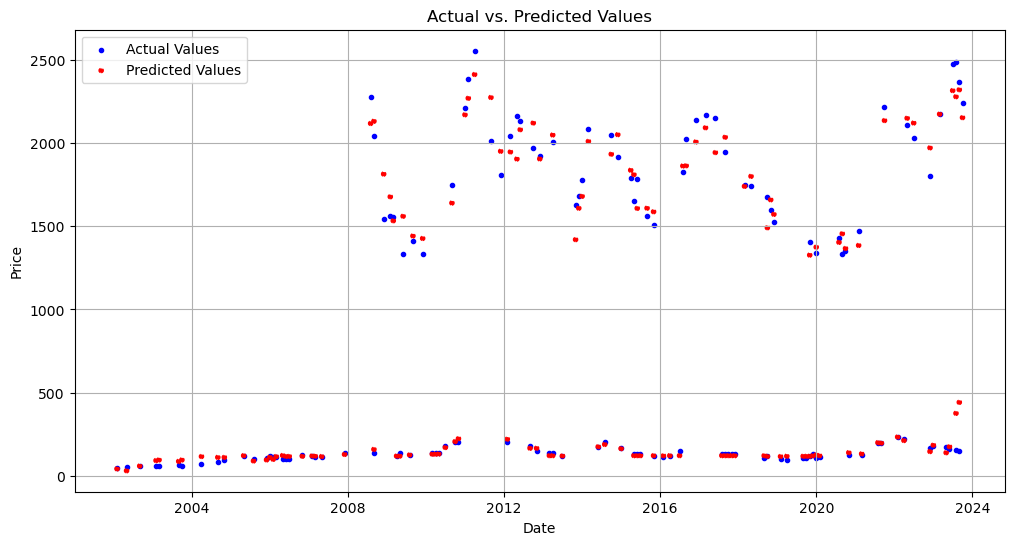

In [69]:
import matplotlib.pyplot as plt
# Predict using the model
y_pred = bst.predict(dvalid)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))

plt.scatter(test_df['date'], y_test, label='Actual Values', color='blue', marker='.')
plt.scatter(test_df['date'], y_pred, label='Predicted Values', color='red', linestyle='--', marker='.')

plt.title('Actual vs. Predicted Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
df_new = df_snd.merge(df_market, on=['date'], how='left') \
           .merge(df_price, on=['date','coffee_type_id','actvsproj'],how='left') \
           .merge(df_coffee_type, on=['coffee_type_id'], how='left')

In [79]:
df_new.head()

,date,coffee_type_id,certified_stock,total_consumption,total_stock,total_supply,total_demand,actvsproj,DXY,USDBRL,price,coffee_type
0,2001-12-31,1,1114.557832,4792.057525,4459.483456,1568.443583,785.610628,act,116.750000,2.311,48.15,Arabica
1,2002-01-31,1,1087.076160,4861.908518,4558.069021,1594.259096,744.775122,act,120.239998,2.413,47.65,Arabica
2,2002-02-28,1,1026.468713,4349.975139,4406.522032,1567.154395,769.710533,act,119.160004,2.365,46.30,Arabica
3,2002-03-31,1,961.625592,4647.049927,4120.613079,1518.538160,806.831154,act,118.620003,2.325,59.20,Arabica
4,2002-04-30,1,892.695043,4755.849295,3905.861783,1479.966651,806.272717,act,115.190002,2.361,52.85,Arabica


In [87]:
df_new.drop(['date','coffee_type_id','coffee_type_id','coffee_type','actvsproj'],axis=1, inplace=True)

Index(['certified_stock', 'total_consumption', 'total_stock', 'total_supply',
       'total_demand', 'DXY', 'USDBRL', 'price'],
      dtype='object')
Index(['certified_stock', 'total_consumption', 'total_stock', 'total_supply',
       'total_demand', 'DXY', 'USDBRL', 'price'],
      dtype='object')


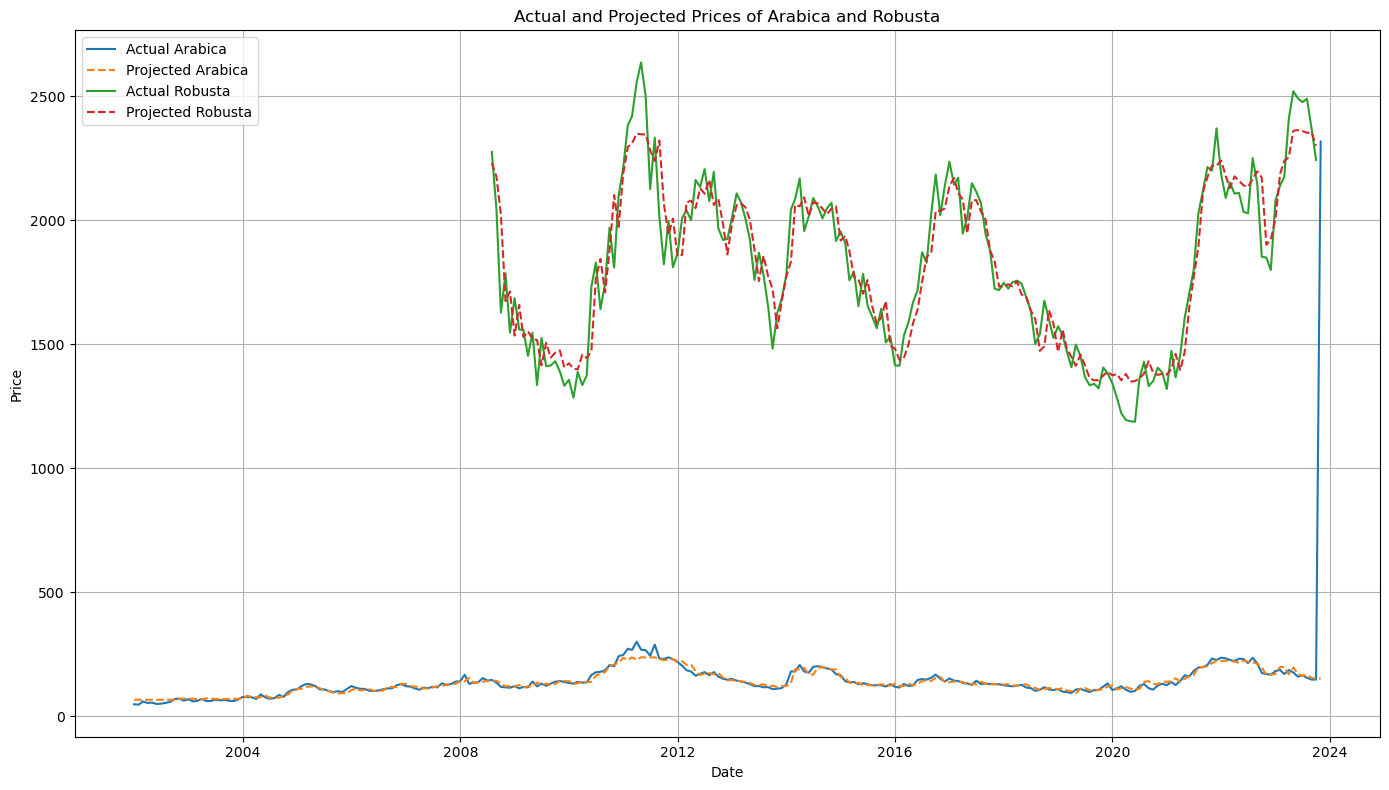

In [84]:
import matplotlib.pyplot as plt

# Prepare a dictionary to store the predictions for each coffee type
predictions = {}

for coffee in coffee_types:
    # Get the appropriate model from the 'models' dictionary
    model = models[coffee]
    
    # Filter the testing data for the specific coffee type
    test_data = df[df['coffee_type'] == coffee].sort_values(by='date')
    
    X_test = test_data.drop(columns=['target', 'date', 'coffee_type'])
    print(X_test.columns)
    y_test_actual = test_data['target'].values
    test_dates = test_data['date'].values
    
    # Predict the prices using the XGBoost model
    dtest = xgb.DMatrix(X_test)
    y_test_pred = model.predict(dtest)
    
    predictions[coffee] = {
        'dates': test_dates,
        'actual': y_test_actual,
        'predicted': y_test_pred
    }

# Now plot the actual and projected prices for both coffee types
plt.figure(figsize=(14, 8))

for coffee in coffee_types:
    plt.plot(predictions[coffee]['dates'], predictions[coffee]['actual'], label=f'Actual {coffee}')
    plt.plot(predictions[coffee]['dates'], predictions[coffee]['predicted'], linestyle='--', label=f'Projected {coffee}')

plt.title('Actual and Projected Prices of Arabica and Robusta')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Future Considerations
1. Add lagged features, such as a sequence of features price N months prior. Add seasonal features like categorical features of summer, fall, winter, spring.
2. Quantile regression to generate prediciton confidence intervals
3. Try basic time series model like ARIMA and compare performance to current. One could also try a RNN time-series model, but this is likely to overfit.